### Part -1 

#### Use OpenCV or any other library for input pipeline (transformations, augmentations, rotation, etc..)


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from mnist import MNIST

In [3]:
mndata = MNIST('samples')
images, labels = mndata.load_training()
images1, labels1 = mndata.load_testing()

In [4]:
#Converting list into numpy arrays
train_x=np.array(images)
train_y=np.array(labels)
test_x=np.array(images1)
test_y=np.array(labels1)

In [5]:
#Reshaping in Conventional Form
train_x=train_x.T
test_x=test_x.T
train_y=train_y.reshape(1,60000)
test_y=test_y.reshape(1,10000)

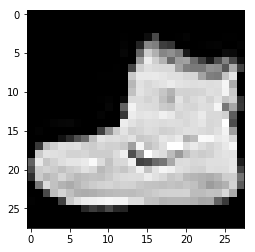

In [6]:
#Printing Image
plt.imshow(train_x[:,0].reshape((28,28)), interpolation='nearest',cmap='gray')
plt.show()

In [7]:
#Importing Necessary Libraries for Transformation
from skimage.transform import rescale
from skimage.transform import rotate
from skimage import exposure
import warnings
warnings.filterwarnings("ignore")

#### Transformation Functions:

In [8]:
def image_with_rotation(image,degree):
    return rotate(image, degree)

In [9]:
def horizontal_flip(image):
    return image[:, ::-1]

In [10]:
def vertical_flip(image):
    return image[::-1, :]

In [11]:
def better_contrast(image):
    v_min, v_max = np.percentile(image, (0.2, 99.8))
    return exposure.rescale_intensity(image, in_range=(v_min, v_max))

Below Augmentation is done sequentially on train data so labels in rotated_image,hori_flip,etc. are retained in the order of training set.

In [12]:
rotated_image=[]
hori_flip=[]
verti_flip=[]
better_cont=[]
for i in range(0,60000):
    image=train_x[:,i].reshape((28,28))
    rotated_image.append(image_with_rotation(image,90))
    hori_flip.append(horizontal_flip(image))
    verti_flip.append(vertical_flip(image))
    better_cont.append(better_contrast(image))

In [13]:
# plt.imshow(np.array(better_cont)[2].reshape((28,28)),interpolation='nearest',cmap='gray')
# plt.show()

In [14]:
#Reshaping in conventional Form
rotated_image=np.array(rotated_image).reshape((60000,-1)).T
hori_flip=np.array(hori_flip).reshape((60000,-1)).T
verti_flip=np.array(verti_flip).reshape((60000,-1)).T
better_cont=np.array(better_cont).reshape((60000,-1)).T

In [15]:
train_x=np.concatenate((train_x,rotated_image),axis=1)
train_x=np.concatenate((train_x,hori_flip),axis=1)
train_x=np.concatenate((train_x,verti_flip),axis=1)
train_x=np.concatenate((train_x,better_cont),axis=1)

In [16]:
train_y_temp=train_y.copy()

In [17]:
train_y=np.concatenate((train_y,train_y_temp),axis=1)
train_y=np.concatenate((train_y,train_y_temp),axis=1)
train_y=np.concatenate((train_y,train_y_temp),axis=1)
train_y=np.concatenate((train_y,train_y_temp),axis=1)

In [18]:
#Normalizing
train_x=train_x/255
test_x=test_x/255

In [19]:
train_x.shape

(784, 300000)

In [20]:
train_y.shape

(1, 300000)

### Part -2
#### Build a CNN network from scratch using tensorflow on transformed data with highest validation accuracy & use that  model for inference.

No Dropout and Mini batch Input.Trained for subset of data from row 30k to 90k.And fed randomly to the network using batch sie of 128.

A 'nan' value for Minibatch Loss came when whole data was used as input.


In [21]:
# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 1. # Dropout, probability to keep units

In [22]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability)

In [23]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [24]:
def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

In [25]:
# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [26]:
# Store layers weight & bias

weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

Instructions for updating:
Colocations handled automatically by placer.


In [53]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [54]:
# Initializing the variables
init = tf.initialize_all_variables()

In [55]:
saver=tf.train.Saver()

In [56]:
digits = 10 # No. of Classes
m=300000 #Training Instances

Y_new = np.eye(digits)[train_y.astype('int32')]
Y_new = Y_new.T.reshape(digits,m)
Y_test = np.eye(digits)[test_y.astype('int32')]
Y_test = Y_test.T.reshape(digits,10000)

In [57]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [58]:
x_=train_x.T[30000:90000,:]
y_=Y_new.T[30000:90000,:]

In [59]:
# Parameters
training_iters = 60000
batch_size = 100
display_step = 10

In [60]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    loss_=[]
    epoch_=[]
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        #Creating Batch of Train data
        batch_x, batch_y = next_batch(batch_size,x_,y_)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,keep_prob: dropout})
        
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,y: batch_y,keep_prob: 1.})
            print("Iter " + str(step * batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        loss_.append(loss)
        epoch_.append(step)
        step += 1
    #Saving Model    
    save_path = saver.save(sess, "./fashion-mnist-model.ckpt")
    print("Optimization Finished!")
    print('Testing accuracy:', sess.run(accuracy, feed_dict={x: test_x.T[:1000,:], y:Y_test.T[:1000,:], keep_prob:1.}))
    

Iter 1000, Minibatch Loss= 44783.761719, Training Accuracy= 0.13000
Iter 2000, Minibatch Loss= 30280.001953, Training Accuracy= 0.13000
Iter 3000, Minibatch Loss= 21030.289062, Training Accuracy= 0.10000
Iter 4000, Minibatch Loss= 17209.458984, Training Accuracy= 0.13000
Iter 5000, Minibatch Loss= 15466.257812, Training Accuracy= 0.11000
Iter 6000, Minibatch Loss= 13773.919922, Training Accuracy= 0.12000
Iter 7000, Minibatch Loss= 11252.800781, Training Accuracy= 0.14000
Iter 8000, Minibatch Loss= 6575.095215, Training Accuracy= 0.27000
Iter 9000, Minibatch Loss= 5545.330078, Training Accuracy= 0.29000
Iter 10000, Minibatch Loss= 3852.940918, Training Accuracy= 0.23000
Iter 11000, Minibatch Loss= 7272.272949, Training Accuracy= 0.29000
Iter 12000, Minibatch Loss= 6273.807617, Training Accuracy= 0.27000
Iter 13000, Minibatch Loss= 5826.368652, Training Accuracy= 0.20000
Iter 14000, Minibatch Loss= 6304.845703, Training Accuracy= 0.21000
Iter 15000, Minibatch Loss= 4548.102539, Training 

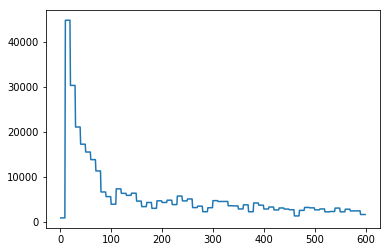

In [61]:
import matplotlib.pyplot as plt
plt.plot(epoch_,loss_)
plt.show()

### Part -3
#### Modify the above architecture by using Batch normalization, dropout, ReduceLRonPlateau, Early stopping.


With Dropout =0.5

In [62]:
# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.50 # Dropout, probability to keep units

In [63]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability)

In [64]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [65]:
def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

In [66]:
# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [67]:
# Store layers weight & bias

weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [68]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

In [71]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initializing the variables
init = tf.initialize_all_variables()

In [72]:
digits = 10 # No. of Classes
m=300000 #Training Instances

Y_new = np.eye(digits)[train_y.astype('int32')]
Y_new = Y_new.T.reshape(digits,m)
Y_test = np.eye(digits)[test_y.astype('int32')]
Y_test = Y_test.T.reshape(digits,10000)

In [73]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [74]:
x_=train_x.T[30000:90000,:]
y_=Y_new.T[30000:90000,:]

In [75]:
# Parameters
training_iters = 60000
batch_size = 100
display_step = 10

In [77]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    loss_drp=[]
    epoch_drp=[]
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        #Creating Batch of Train data
        batch_x, batch_y = next_batch(batch_size,x_,y_)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,keep_prob: dropout})
        
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,y: batch_y,keep_prob: 0.5})
            print("Iter " + str(step * batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        loss_drp.append(loss)
        epoch_drp.append(step)
        step += 1
    #Saving Model    
    save_path = saver.save(sess, "./fashion-mnist-model.ckpt")
    print("Optimization Finished!")
    print('Testing accuracy:', sess.run(accuracy, feed_dict={x: test_x.T[:1000,:], y:Y_test.T[:1000,:], keep_prob:1.}))
    

Iter 1000, Minibatch Loss= 17314.943359, Training Accuracy= 0.19000
Iter 2000, Minibatch Loss= 4622.246094, Training Accuracy= 0.29000
Iter 3000, Minibatch Loss= 1254.456787, Training Accuracy= 0.33000
Iter 4000, Minibatch Loss= 1239.172729, Training Accuracy= 0.32000
Iter 5000, Minibatch Loss= 1017.699219, Training Accuracy= 0.31000
Iter 6000, Minibatch Loss= 513.760193, Training Accuracy= 0.33000
Iter 7000, Minibatch Loss= 275.810333, Training Accuracy= 0.43000
Iter 8000, Minibatch Loss= 411.192810, Training Accuracy= 0.36000
Iter 9000, Minibatch Loss= 430.672485, Training Accuracy= 0.30000
Iter 10000, Minibatch Loss= 355.303680, Training Accuracy= 0.25000
Iter 11000, Minibatch Loss= 302.715576, Training Accuracy= 0.31000
Iter 12000, Minibatch Loss= 257.783569, Training Accuracy= 0.29000
Iter 13000, Minibatch Loss= 300.936218, Training Accuracy= 0.34000
Iter 14000, Minibatch Loss= 163.911438, Training Accuracy= 0.30000
Iter 15000, Minibatch Loss= 222.036621, Training Accuracy= 0.3100

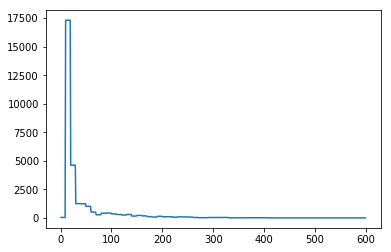

In [78]:
plt.plot(epoch_drp,loss_drp)
plt.show()

##### BatchNorm

New Arch with Batch Norm of Input.

In [98]:
# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.50 # Dropout, probability to keep units

In [99]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability)
training = tf.placeholder_with_default(False, shape=(), name='training')

In [100]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [101]:
def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

In [102]:
# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    
    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    #Batch Norm
    batchNorm1 = tf.layers.batch_normalization(conv1, training=training, momentum=0.9)
    
    
    # Convolution Layer
    conv2 = conv2d(batchNorm1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    #Batch Norm
    batchNorm2 = tf.layers.batch_normalization(conv2, training=training, momentum=0.9)
    
    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(batchNorm2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    #Batch Norm
    batchNorm3 = tf.layers.batch_normalization(fc1, training=training, momentum=0.9)
    out = tf.add(tf.matmul(batchNorm3, weights['out']), biases['out'])
    return out

In [103]:
# Store layers weight & bias

weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [104]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

In [105]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initializing the variables
init = tf.initialize_all_variables()

In [106]:
digits = 10 # No. of Classes
m=300000 #Training Instances

Y_new = np.eye(digits)[train_y.astype('int32')]
Y_new = Y_new.T.reshape(digits,m)
Y_test = np.eye(digits)[test_y.astype('int32')]
Y_test = Y_test.T.reshape(digits,10000)

In [107]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [108]:
x_=train_x.T[30000:90000,:]
y_=Y_new.T[30000:90000,:]

In [109]:
# Parameters
training_iters = 60000
batch_size = 100
display_step = 10

In [113]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    loss_bn=[]
    epoch_bn=[]
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        #Creating Batch of Train data
        batch_x, batch_y = next_batch(batch_size,x_,y_)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,keep_prob: dropout})
        
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,y: batch_y,keep_prob: 0.5})
            print("Iter " + str(step * batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        loss_bn.append(loss)
        epoch_bn.append(step)
        step += 1
    #Saving Model    
    save_path = saver.save(sess, "./fashion-mnist-model.ckpt")
    print("Optimization Finished!")
    print('Testing accuracy:', sess.run(accuracy, feed_dict={x: test_x.T[:1000,:], y:Y_test.T[:1000,:], keep_prob:1.}))
    

Iter 1000, Minibatch Loss= 43262.371094, Training Accuracy= 0.15000
Iter 2000, Minibatch Loss= 29462.525391, Training Accuracy= 0.23000
Iter 3000, Minibatch Loss= 21006.082031, Training Accuracy= 0.21000
Iter 4000, Minibatch Loss= 17701.966797, Training Accuracy= 0.20000
Iter 5000, Minibatch Loss= 18043.457031, Training Accuracy= 0.21000
Iter 6000, Minibatch Loss= 16863.439453, Training Accuracy= 0.31000
Iter 7000, Minibatch Loss= 11647.245117, Training Accuracy= 0.23000
Iter 8000, Minibatch Loss= 12499.293945, Training Accuracy= 0.33000
Iter 9000, Minibatch Loss= 11341.187500, Training Accuracy= 0.33000
Iter 10000, Minibatch Loss= 9365.749023, Training Accuracy= 0.35000
Iter 11000, Minibatch Loss= 4448.995605, Training Accuracy= 0.32000
Iter 12000, Minibatch Loss= 6128.976074, Training Accuracy= 0.40000
Iter 13000, Minibatch Loss= 6085.316406, Training Accuracy= 0.38000
Iter 14000, Minibatch Loss= 4995.008789, Training Accuracy= 0.37000
Iter 15000, Minibatch Loss= 4329.320801, Trainin

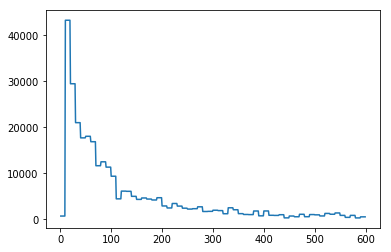

In [114]:
plt.plot(epoch_bn,loss_bn)
plt.show()